# Diplodatos Kaggle Competition

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Explore the data and learn from it
1. Try different models and see which one fits the best the given data
1. Get a higher score than the given one in the current baseline example
1. Try to get the highest score in the class :)

In [33]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lib

## Read Data

In [34]:
train_df = pd.read_csv("../data/travel_insurance_prediction_train.csv")
test_df = pd.read_csv("../data/travel_insurance_prediction_test.csv")

## Explore the Data

Is your task to explore the data, do analysis over it and get insights, then use those insights to better pick a model.

In [35]:
train_df.head()

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,1,33,Private Sector/Self Employed,Yes,550000,6,0,No,No,1
1,2,28,Private Sector/Self Employed,Yes,800000,7,0,Yes,No,0
2,3,31,Private Sector/Self Employed,Yes,1250000,4,0,No,No,0
3,4,31,Government Sector,No,300000,7,0,No,No,0
4,5,28,Private Sector/Self Employed,Yes,1250000,3,0,No,No,0


In [36]:
test_df.head()

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
0,1491,26,Private Sector/Self Employed,Yes,1400000,7,1,Yes,Yes
1,1492,28,Private Sector/Self Employed,Yes,750000,5,1,Yes,No
2,1493,31,Government Sector,Yes,1500000,4,0,Yes,Yes
3,1494,28,Private Sector/Self Employed,Yes,1400000,3,0,No,Yes
4,1495,33,Private Sector/Self Employed,Yes,1500000,4,0,Yes,Yes


**TravelInsurance** is the column that we should predict. That column is not present in the test set.

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer             1490 non-null   int64 
 1   Age                  1490 non-null   int64 
 2   Employment Type      1490 non-null   object
 3   GraduateOrNot        1490 non-null   object
 4   AnnualIncome         1490 non-null   int64 
 5   FamilyMembers        1490 non-null   int64 
 6   ChronicDiseases      1490 non-null   int64 
 7   FrequentFlyer        1490 non-null   object
 8   EverTravelledAbroad  1490 non-null   object
 9   TravelInsurance      1490 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 116.5+ KB


In [38]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer             497 non-null    int64 
 1   Age                  497 non-null    int64 
 2   Employment Type      497 non-null    object
 3   GraduateOrNot        497 non-null    object
 4   AnnualIncome         497 non-null    int64 
 5   FamilyMembers        497 non-null    int64 
 6   ChronicDiseases      497 non-null    int64 
 7   FrequentFlyer        497 non-null    object
 8   EverTravelledAbroad  497 non-null    object
dtypes: int64(5), object(4)
memory usage: 35.1+ KB


In [39]:
train_df.describe()

,Customer,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1490.000000,1490.000000,1.490000e+03,1490.000000,1490.000000,1490.000000
mean,745.500000,29.667114,9.278188e+05,4.777181,0.275839,0.357047
std,430.270264,2.880994,3.811715e+05,1.640248,0.447086,0.479290
min,1.000000,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,373.250000,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,745.500000,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,1117.750000,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,1490.000000,35.000000,1.800000e+06,9.000000,1.000000,1.000000


In [40]:
test_df.describe()

,Customer,Age,AnnualIncome,FamilyMembers,ChronicDiseases
count,497.000000,497.000000,4.970000e+02,497.000000,497.000000
mean,1739.000000,29.593561,9.481891e+05,4.686117,0.285714
std,143.615807,3.014715,3.640841e+05,1.516731,0.452209
min,1491.000000,25.000000,3.000000e+05,2.000000,0.000000
25%,1615.000000,28.000000,6.500000e+05,4.000000,0.000000
50%,1739.000000,29.000000,9.500000e+05,4.000000,0.000000
75%,1863.000000,32.000000,1.250000e+06,6.000000,1.000000
max,1987.000000,35.000000,1.750000e+06,9.000000,1.000000


## Baseline

In this section we present a baseline based on a decision tree classifier.

Many of the attributes are binary, there are a couple of numeric attributes, we might be able to one-hot (e.g. family members), or event discretize (age and anual income), this will come more clearly after the EDA.

In [41]:
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

### Transform the columns into features

First we need to transform the columns into features. The type of features we use will have a direct impact on the final result. In this example we decided to discretize some numeric features and make a one hot encoding of others. The number of bins, what we use as a one hot encoding, etc, is all up to you to try it out.

In [42]:
transformer = make_column_transformer(
    (KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"), ["Age", "AnnualIncome"]),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"),
     ["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]),
    remainder="passthrough")

We transform the train and test data. In order to avoid overfitting is better to remove the `Customer` column and we don't want the `TravelInsurance` column as part of the attributes either.

In [43]:
# The data for training the model
X_train = transformer.fit_transform(train_df.drop(columns=["Customer", "TravelInsurance"]))
y_train = train_df["TravelInsurance"].values

# The test data is only for generating the submission
X_test = transformer.transform(test_df.drop(columns=["Customer"]))


### Grid Search

We do a Grid Search for the Decision Tree (this can be replaced by a randomized search if the model is too complex).

In [44]:
search_params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [3, 6, 10]
}
tree = DecisionTreeClassifier(random_state=42)
tree_clf = GridSearchCV(tree, search_params, cv=5, scoring='f1', n_jobs=-1)
tree_clf.fit(X_train, y_train)

best_tree_clf = tree_clf.best_estimator_

### Check Results

We can print the results of the best estimator found on the whole training set (we could also set apart a validation set if we find it useful).

In [45]:
print(classification_report(y_train, best_tree_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       958
           1       0.86      0.66      0.75       532

    accuracy                           0.84      1490
   macro avg       0.85      0.80      0.82      1490
weighted avg       0.84      0.84      0.84      1490



## Generate the output

The last thing we do is generating a file that should be *submitted* on kaggle

In [46]:
test_id = test_df["Customer"]
test_pred = best_tree_clf.predict(X_test)

submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["Customer", "TravelInsurance"])
submission.to_csv("../data/travel_insurance_submission.csv", header=True, index=False)

# Desarrollo

## Funciones para descrbir el DF

## Descripción de DF de entrenamiento

In [47]:
lib.summarize_categoricals(train_df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values
Customer,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1490,0
Age,"[33, 28, 31, 25, 26, 35, 27, 34, 32, 29, 30]",11,0
Employment Type,"[Private Sector/Self Employed, Government Sector]",2,0
GraduateOrNot,"[Yes, No]",2,0
AnnualIncome,"[550000, 800000, 1250000, 300000, 1350000, 400...",30,0
FamilyMembers,"[6, 7, 4, 3, 5, 2, 8, 9]",8,0
ChronicDiseases,"[0, 1]",2,0
FrequentFlyer,"[No, Yes]",2,0
EverTravelledAbroad,"[No, Yes]",2,0
TravelInsurance,"[1, 0]",2,0


In [48]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer,1490.0,745.500000,430.270264,1.0,373.25,745.5,1117.75,1490.0
Age,1490.0,29.667114,2.880994,25.0,28.00,29.0,32.00,35.0
AnnualIncome,1490.0,927818.791946,381171.545186,300000.0,600000.00,900000.0,1250000.00,1800000.0
FamilyMembers,1490.0,4.777181,1.640248,2.0,4.00,5.0,6.00,9.0
ChronicDiseases,1490.0,0.275839,0.447086,0.0,0.00,0.0,1.00,1.0
TravelInsurance,1490.0,0.357047,0.479290,0.0,0.00,0.0,1.00,1.0


In [49]:
to_cast = lib.return_categoricals(train_df, threshold=5)
train_df_cast = lib.to_categorical(to_cast, train_df)
train_df_cast = train_df_cast.drop(columns=["Customer"])

train_df_cast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Age                  1490 non-null   int64   
 1   Employment Type      1490 non-null   category
 2   GraduateOrNot        1490 non-null   category
 3   AnnualIncome         1490 non-null   int64   
 4   FamilyMembers        1490 non-null   int64   
 5   ChronicDiseases      1490 non-null   category
 6   FrequentFlyer        1490 non-null   category
 7   EverTravelledAbroad  1490 non-null   category
 8   TravelInsurance      1490 non-null   category
dtypes: category(6), int64(3)
memory usage: 44.3 KB


## Correlación entre variables cuantitativas

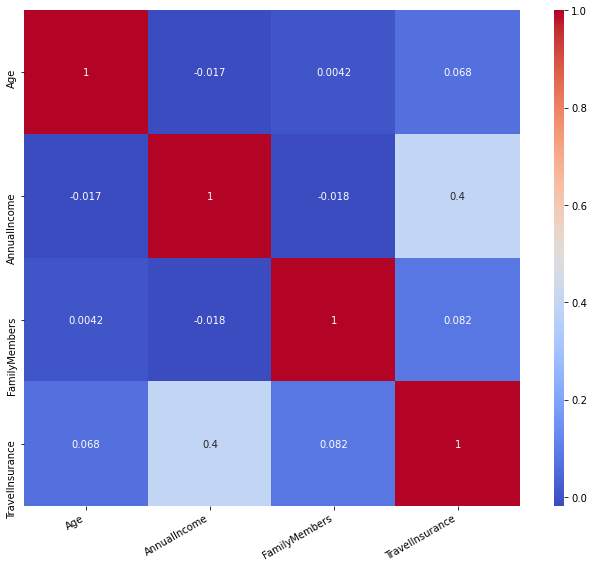

In [50]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=train_df_cast.astype({'TravelInsurance': 'int64'}).corr(),
            annot=True, cmap='coolwarm', cbar_kws={'aspect': 50},
            square=True, ax=ax)
plt.xticks(rotation=30, ha='right');
plt.tight_layout()

**AnnualIncome** es la variable continua que más correlacionada esta con TraverlInsurance

## Correlación entre variables cualitativas

Funciones para armar matriz de correlación de variables caulitativas

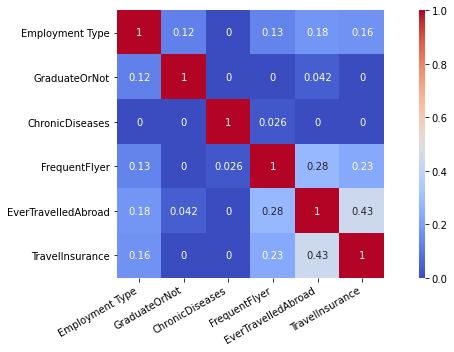

In [51]:
from scipy.stats import chi2_contingency

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(lib.categorical_corr_matrix(train_df_cast), annot=True, cmap='coolwarm', 
            cbar_kws={'aspect': 50}, square=True, ax=ax)
plt.xticks(rotation=30, ha='right');
plt.tight_layout()

**EverTravelledAbroad, FrequentFlyer y Employment Type** son las variables categóricas más correlacionadas con TraverlInsurance

## Distribución de frecuencia de variables categóricas

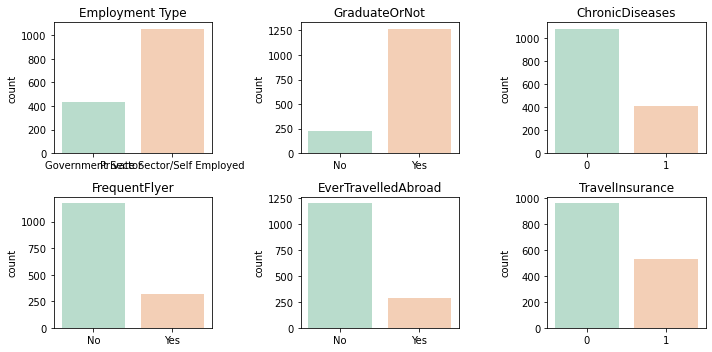

In [52]:
import pandas as pd

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
titles = list(train_df_cast.select_dtypes(include='category'))

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.countplot(x=title, data=train_df_cast, palette='Pastel2', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')

plt.tight_layout()

## Distribución de frecuencia de variables continuas

['Age', 'AnnualIncome', 'FamilyMembers']


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

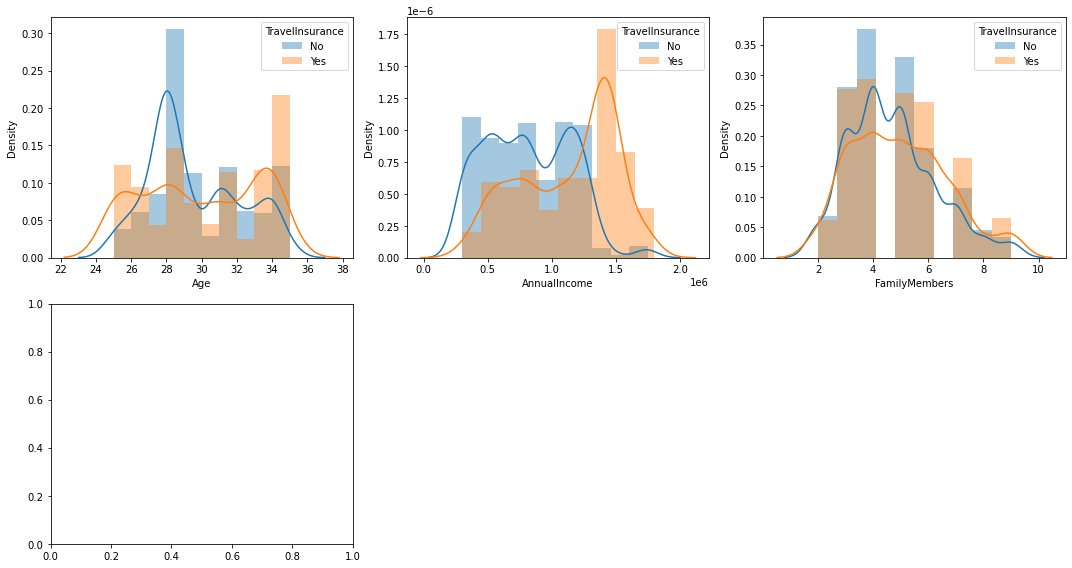

In [53]:
df_grouped = train_df_cast.groupby(by='TravelInsurance')
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
titles = list(train_df_cast.select_dtypes(exclude='category'))

print (titles)

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:

    sns.distplot(df_grouped.get_group(0)[title], bins=10, ax=ax, label='No')
    sns.distplot(df_grouped.get_group(1)[title], bins=10, ax=ax, label='Yes')
    ax.legend(title='TravelInsurance')

axs.flat[-1].remove()
axs.flat[-2].remove()
fig.tight_layout()

## Observaciones 

- A mayor anual income, mayor grado de compra de seguros
- A mayor edad, mayor grado de compra de seguros

Conteo de TravelInsurance  en base a  EverTravelledAbroad, FrequentFlyer y Employment Type

Funciones para armar countpltot

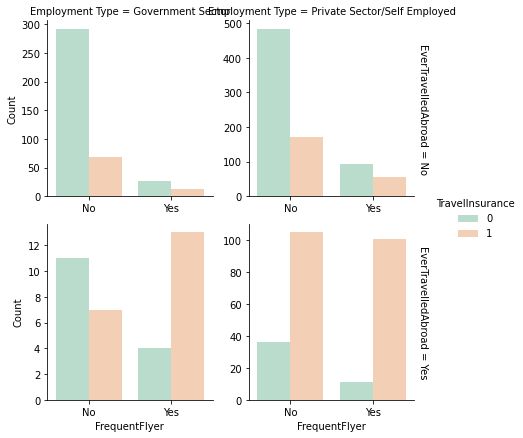

In [54]:
facet = sns.FacetGrid(train_df_cast, row='EverTravelledAbroad', col='Employment Type', sharex=False,
                      sharey=False, margin_titles=True)
facet.map(lib.modified_countplot, x='FrequentFlyer', hue='TravelInsurance',
          palette='Pastel2', facet_generator=facet.facet_data())
facet.set_xlabels('FrequentFlyer')
facet.set_ylabels('Count')
facet.add_legend(title='TravelInsurance');

## Observaciones: 

- EverTraveledAbroad y FrecuentTravelledAbroad = True, tienen gran peso a la hora de indicar si el viajero contrata seguro

In [68]:
#selected_numerical_columns = ['AnnualIncome' , 'Age']

selected_numerical_columns = ['AnnualIncome' , 'Age' , 'FamilyMembers' ]



In [69]:
#selected_categorical_columns = ['EverTravelledAbroad', 'FrequentFlyer']

selected_categorical_columns = ['EverTravelledAbroad', 'FrequentFlyer' , 'ChronicDiseases' , 'Employment Type' , 'GraduateOrNot']


## Seteo seed_val

Hacemos el seteo de la variable seed_val para que los experimentos puedan ser repetidos sin que los valore aleatorios cambien entre corrida y corrida


In [70]:
seed_val = 42

## Particionamos el Data Set en train y test. 
Recordemos que el test que tenemos, no tiene los valores y puesto que justmente estos valores tiene que ser calculados y subidos a kaggle para ver como performa nuestro modelo

In [71]:
from sklearn.model_selection import train_test_split

x_train_df_split, x_test_df_split, y_train_split, y_test_split = train_test_split(train_df_cast.drop(columns = ['TravelInsurance']), train_df_cast['TravelInsurance'], test_size=0.25, random_state=seed_val,
                               shuffle=True, stratify=train_df_cast['TravelInsurance'])

## Transformes

In [139]:
transformer = make_column_transformer(
    (KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"), ['AnnualIncome' , 'Age']),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"),
      ["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]),
    remainder="passthrough")

In [140]:
# Scalers

In [151]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [152]:
selected_transformer = transformer

In [158]:
x_train_df_split_transformed = selected_transformer.fit_transform(x_train_df_split[selected_numerical_columns +  selected_categorical_columns])

x_test_df_cast_split_transformed = selected_transformer.transform(x_test_df_split[selected_numerical_columns +  selected_categorical_columns])

x_train_df_split_transformed_scaled = sc.fit_transform(x_train_df_split_transformed)

x_test_df_cast_split_transformed_scaled = sc.transform(x_test_df_cast_split_transformed)



X_train_scaled = sc.fit_transform(X_train)


# Entrenamientos

Metrica para validar la eficiencia / eficacia de los modelos

In [76]:
from sklearn import metrics

primary_eval_metric = metrics.f1_score

In [77]:
feature_names = selected_numerical_columns +  selected_categorical_columns

Nombre de los lables Y

In [78]:
confusion_lbs = ['No TravelInsurance', 'TravelInsurance']

## Logistic Regression

In [79]:
from sklearn.linear_model import LogisticRegression

search_params1 = {
    'tol': [ 0.01 , 0.001 , 0.0001 , 0.1],
    'penalty': ['l2' , 'l1'],
    'solver': ['liblinear' , 'saga' ],
    'class_weight' : ['balanced']
}


search_params = {
    'tol': [ 0.0001 , 0.001 , 0.0001 , 0.1],
    'penalty': ['l2'],
    'solver': ['liblinear' , 'newton-cg', 'lbfgs', 'sag' ],
    'class_weight' : ['balanced']
}



lgr = LogisticRegression()

lgr_cv = GridSearchCV(estimator =  LogisticRegression(), param_grid = search_params, cv=5, scoring='f1', n_jobs=-1 , verbose = 0 , refit = True  )

lgr_cv.fit(x_train_df_split_transformed, y_train_split)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'penalty': ['l2'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag'],
                         'tol': [0.0001, 0.001, 0.0001, 0.1]},
             scoring='f1')

In [80]:
lgr_cv.best_estimator_

LogisticRegression(class_weight='balanced', solver='liblinear', tol=0.1)

LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=500, n_jobs=-1,
                     random_state=42, scoring='f1', solver='liblinear',
                     tol=0.1)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 1117 samples
 Test Size: 373 samples
---------------------------------------------
Training Time: 0.056 seconds
 Testing Time: 0.0 seconds
---------------------------------------------
Train Accuracy:  0.7403760071620412
 Test Accuracy:  0.707774798927614
---------------------------------------------
Train F1 Score:  0.6319796954314721
 Test F1 Score:  0.585551330798479

---------------------------------------------
 Area Under ROC (test):  0.7344141604010025
---------------------------------------------
Model Memory Size: 10.02 kB

=============================> CLASSIFICATION REPORT <===================================
                    precision    recall  f1-score   support

No TravelInsurance       0.7

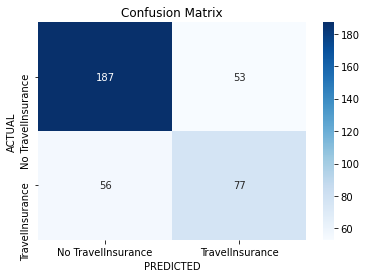


=======================================> PLOTS <=========================================


ValueError: Length of passed values is 19, index implies 8.

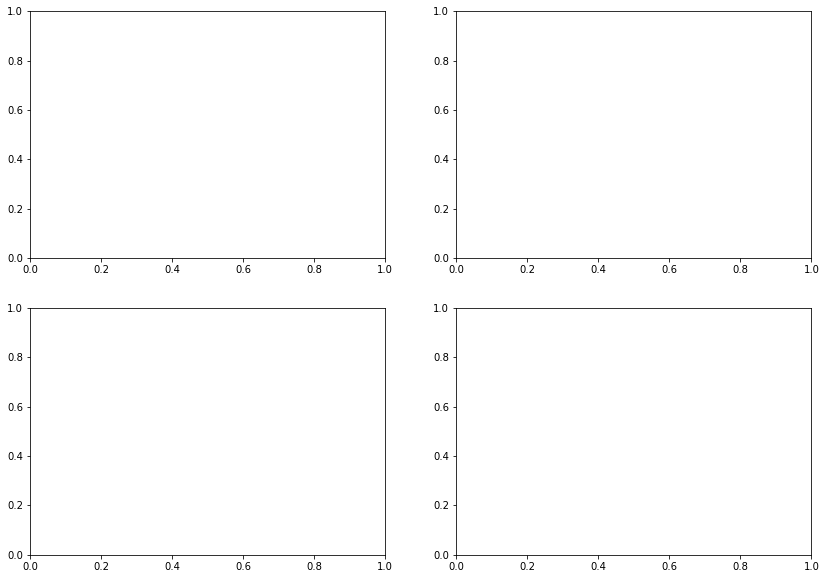

In [82]:
from sklearn.linear_model import LogisticRegressionCV

logit_cv = LogisticRegressionCV(class_weight='balanced', cv=5,
                                max_iter=500, penalty='l2',
                                scoring='f1', solver='liblinear',
                                n_jobs=-1, random_state=seed_val,
                                refit=True, tol=0.1, verbose=0)




logit_cv, logit_report = lib.report(logit_cv, x_train_df_split_transformed, y_train_split,
                                x_test_df_cast_split_transformed, y_test_split,
                                display_scores=[primary_eval_metric],
                                importance_plot=True,
                                feature_labels=feature_names,
                                confusion_labels=confusion_lbs)

In [92]:
logit_cv = LogisticRegression(class_weight='balanced',
                                max_iter=500, penalty='l2',
                                solver='liblinear',
                                n_jobs=-1, random_state=seed_val,
                                tol=0.1, verbose=0)

In [93]:
logit_cv.fit(X_train, y_train)
print(classification_report(y_train, logit_cv.predict(X_train)))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       958
           1       0.64      0.63      0.63       532

    accuracy                           0.74      1490
   macro avg       0.72      0.72      0.72      1490
weighted avg       0.74      0.74      0.74      1490



/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


## Decission Tree

In [85]:
search_params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [6, 3, 10]
}

In [86]:
tree_cv = GridSearchCV(estimator =  DecisionTreeClassifier(random_state=seed_val), param_grid = search_params, cv=5, scoring='f1', n_jobs=-1 , verbose = 0 , refit = True  )

tree_cv.fit(x_train_df_split_transformed, y_train_split)


tree_cv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       random_state=42)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 1117 samples
 Test Size: 373 samples
---------------------------------------------
Training Time: 0.003 seconds
 Testing Time: 0.0 seconds
---------------------------------------------
Train Accuracy:  0.8549686660698299
 Test Accuracy:  0.774798927613941
---------------------------------------------
Train F1 Score:  0.7737430167597765
 Test F1 Score:  0.6499999999999999

---------------------------------------------
 Area Under ROC (test):  0.769329573934837
---------------------------------------------
Model Memory Size: 14.61 kB

=============================> CLASSIFICATION REPORT <===================================
                    precision    recall  f1-score   support

No TravelInsurance       0.79      0.88      0.83       240
   TravelInsurance       0.73      0.59      0.65       133

          ac

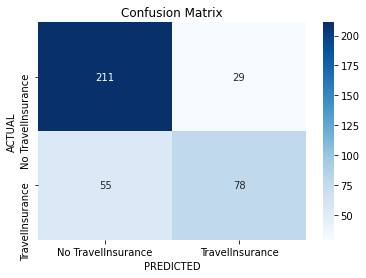


=======================================> PLOTS <=========================================


ValueError: Length of passed values is 19, index implies 8.

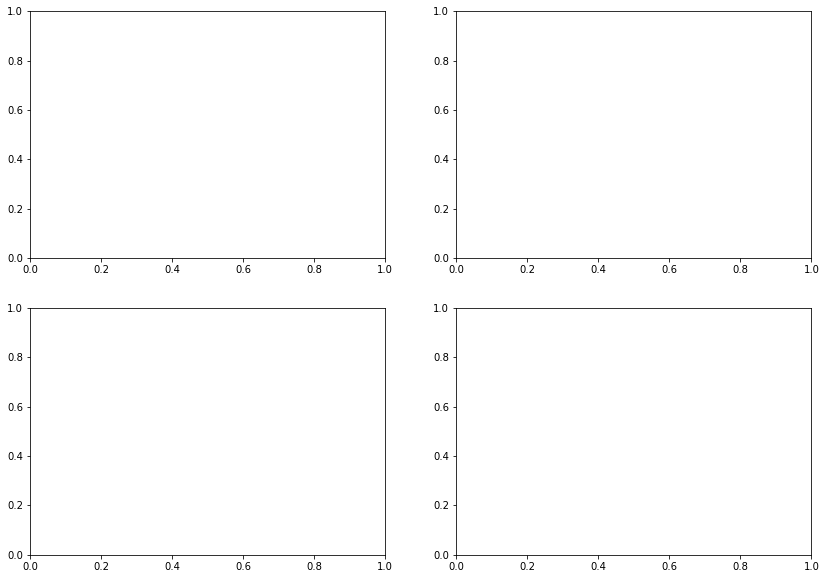

In [88]:
decision_tree = DecisionTreeClassifier(max_depth=10,
                                       random_state=seed_val, min_samples_leaf=5)

decision_tree, decision_tree_report = lib.report(decision_tree,x_train_df_split_transformed, y_train_split,
                                        x_test_df_cast_split_transformed, y_test_split,
                                        display_scores=[primary_eval_metric],
                                        importance_plot=True,
                                        feature_labels=feature_names,
                                        confusion_labels=confusion_lbs)



In [94]:
decision_tree = DecisionTreeClassifier(max_depth=10,
                                       random_state=seed_val, min_samples_leaf=5)

In [95]:
decision_tree.fit(X_train, y_train)
print(classification_report(y_train, decision_tree.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       958
           1       0.86      0.66      0.75       532

    accuracy                           0.84      1490
   macro avg       0.85      0.80      0.82      1490
weighted avg       0.84      0.84      0.84      1490



## RandomForest

In [238]:
[{1:neg_weight, 0:1} for neg_weight in np.arange(1.0, 5.0, 0.5)]

[{1: 1.0, 0: 1},
 {1: 1.5, 0: 1},
 {1: 2.0, 0: 1},
 {1: 2.5, 0: 1},
 {1: 3.0, 0: 1},
 {1: 3.5, 0: 1},
 {1: 4.0, 0: 1},
 {1: 4.5, 0: 1}]

In [242]:
from sklearn.ensemble import RandomForestClassifier

search_params_rf = {
    #'class_weight': ['balanced'],
    #'class_weight':[{0:neg_weight, 1:1} for neg_weight in np.arange(1.0, 5.0, 0.5)],
    'class_weight': [{1:neg_weight, 0:1} for neg_weight in np.arange(1.0, 10.0, 0.5)],
    'max_depth' : [8,9],
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [100, 150, 200]
}



    



rf_cv = GridSearchCV(estimator =  RandomForestClassifier(random_state=seed_val), param_grid = search_params_rf, cv=5, scoring='f1', n_jobs=-1 , verbose = 0 , refit = True  )

rf_cv.fit(x_train_df_split_transformed, y_train_split)

rf_cv.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 1.5}, criterion='entropy',
                       max_depth=8, n_estimators=150, random_state=42)

RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=42)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 1117 samples
 Test Size: 373 samples
---------------------------------------------
Training Time: 0.158 seconds
 Testing Time: 0.013 seconds
---------------------------------------------
Train Accuracy:  0.8683974932855864
 Test Accuracy:  0.7801608579088471
---------------------------------------------
Train F1 Score:  0.7878787878787878
 Test F1 Score:  0.6525423728813559

---------------------------------------------
 Area Under ROC (test):  0.7796835839598998
---------------------------------------------
Model Memory Size: 1363.07 kB

=============================> CLASSIFICATION REPORT <===================================
                    precision    recall  f1-score   support

No TravelInsurance       0.79      0.89      0.84       240
   TravelInsurance       0.75      0.58      0.65       133

  

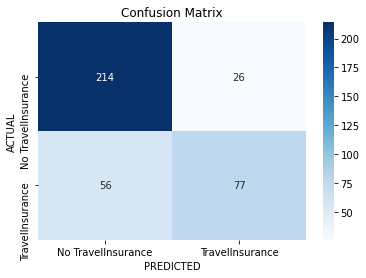


=======================================> PLOTS <=========================================


ValueError: Length of passed values is 19, index implies 8.

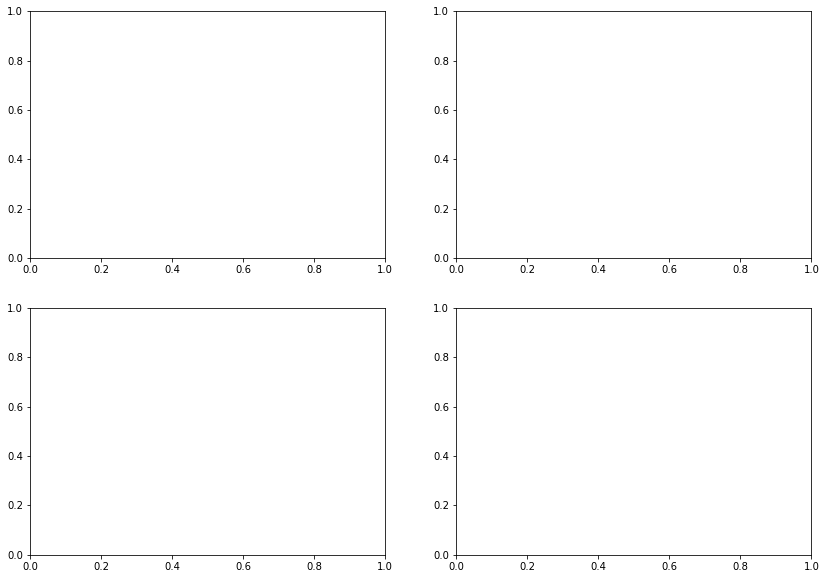

In [241]:
rf = RandomForestClassifier(class_weight='balanced', max_depth=8, criterion='gini', random_state=seed_val)

rf, rf_report = lib.report(rf,x_train_df_split_transformed, y_train_split,
                                        x_test_df_cast_split_transformed, y_test_split,
                                        display_scores=[primary_eval_metric],
                                        importance_plot=True,
                                        feature_labels=feature_names,
                                        confusion_labels=confusion_lbs)

In [228]:
#rfc = RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=42)
rfc = RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       n_estimators=200, random_state=42)


In [229]:
rfc.fit(X_train, y_train)
print(classification_report(y_train, rfc.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       958
           1       0.91      0.65      0.76       532

    accuracy                           0.85      1490
   macro avg       0.87      0.81      0.82      1490
weighted avg       0.86      0.85      0.84      1490



## SVM

In [136]:
from sklearn.svm import SVC

search_params_svc = {
    'C': [1,1.1,1.2],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [3,4,5],
    'class_weight' : [None,'balanced']
    
    
   }


svm_cv = GridSearchCV(estimator =  SVC(random_state = seed_val , probability = True), param_grid = search_params_svc, cv=5, scoring='f1', n_jobs=-1 , verbose = 0 , refit = True  )

svm_cv.fit(x_train_df_split_transformed, y_train_split)

svm_cv.best_estimator_

SVC(C=1, class_weight='balanced', degree=5, kernel='poly', probability=True,
    random_state=42)

SVC(C=1, class_weight='balanced', degree=5, kernel='poly', probability=True,
    random_state=42)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 1117 samples
 Test Size: 373 samples
---------------------------------------------
Training Time: 0.405 seconds
 Testing Time: 0.011 seconds
---------------------------------------------
Train Accuracy:  0.8522829006266786
 Test Accuracy:  0.7935656836461126
---------------------------------------------
Train F1 Score:  0.7577092511013216
 Test F1 Score:  0.6637554585152837

---------------------------------------------
 Area Under ROC (test):  0.7736058897243108
---------------------------------------------
Model Memory Size: 105.59 kB

=============================> CLASSIFICATION REPORT <===================================
                    precision    recall  f1-score   support

No TravelInsurance       0.79      0.92      0.85       240
   TravelInsurance       0.79      0.57     

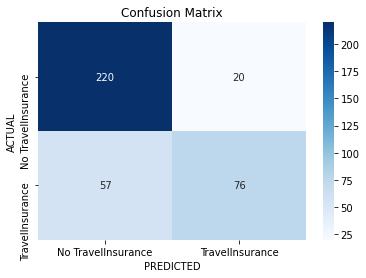


=======================================> PLOTS <=========================================


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


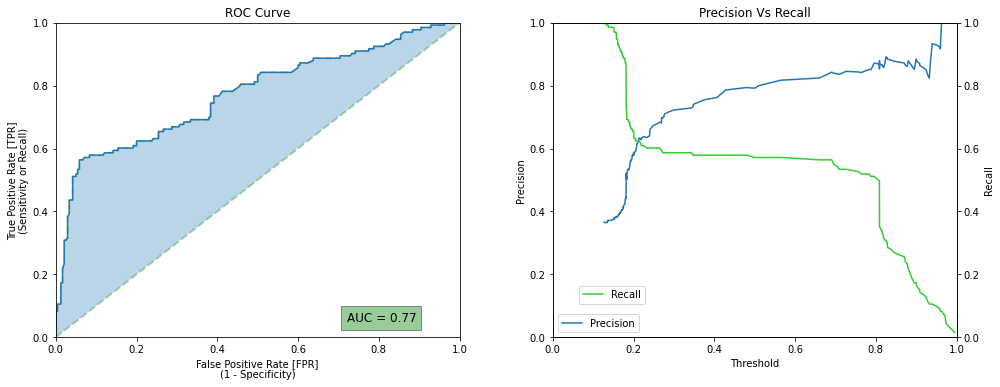

In [137]:
svc = SVC(C=1, degree=5, kernel='poly' ,class_weight='balanced' , random_state=seed_val , probability = True)

svc, svc_report = lib.report(svc,x_train_df_split_transformed, y_train_split,
                                        x_test_df_cast_split_transformed, y_test_split,
                                        display_scores=[primary_eval_metric],
                                        importance_plot=True,
                                        feature_labels=feature_names,
                                        confusion_labels=confusion_lbs)

In [138]:
svc = SVC(C=1.1, degree=4, kernel='poly' , random_state=seed_val , probability = True)
#svc = SVC(C=1, class_weight='balanced', degree=5, kernel='poly', probability=True,
    random_state=seed_val)


IndentationError: unexpected indent (<ipython-input-138-230ac984c5f2>, line 3)

In [ ]:
rfc.fit(X_train, y_train)
print(classification_report(y_train, rfc.predict(X_train)))

## KNN

In [142]:
from sklearn.neighbors import KNeighborsClassifier

search_params_knn = {
    'n_neighbors': [3,4,5],
    'p': [ 2, 3, 4],
    'weights': ['distance']
}



knn_cv = GridSearchCV(estimator =  KNeighborsClassifier(), param_grid = search_params_knn, cv=5, scoring='f1', n_jobs=-1 , verbose = 0 , refit = True  )

knn_cv.fit(x_train_df_split_transformed, y_train_split)

knn_cv.best_estimator_

KNeighborsClassifier(weights='distance')

KNeighborsClassifier(weights='distance')

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 1117 samples
 Test Size: 373 samples
---------------------------------------------
Training Time: 0.001 seconds
 Testing Time: 0.011 seconds
---------------------------------------------
Train Accuracy:  0.9059982094897046
 Test Accuracy:  0.7613941018766756
---------------------------------------------
Train F1 Score:  0.8543689320388349
 Test F1 Score:  0.621276595744681

---------------------------------------------
 Area Under ROC (test):  0.7315946115288221
---------------------------------------------
Model Memory Size: 175.34 kB

=============================> CLASSIFICATION REPORT <===================================
                    precision    recall  f1-score   support

No TravelInsurance       0.78      0.88      0.83       240
   TravelInsurance       0.72      0.55      0.62       133

          accuracy                       

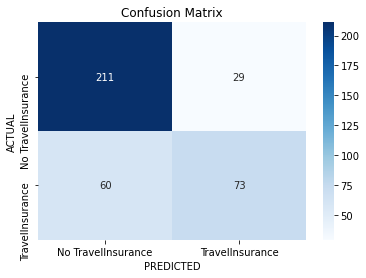


=======================================> PLOTS <=========================================


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


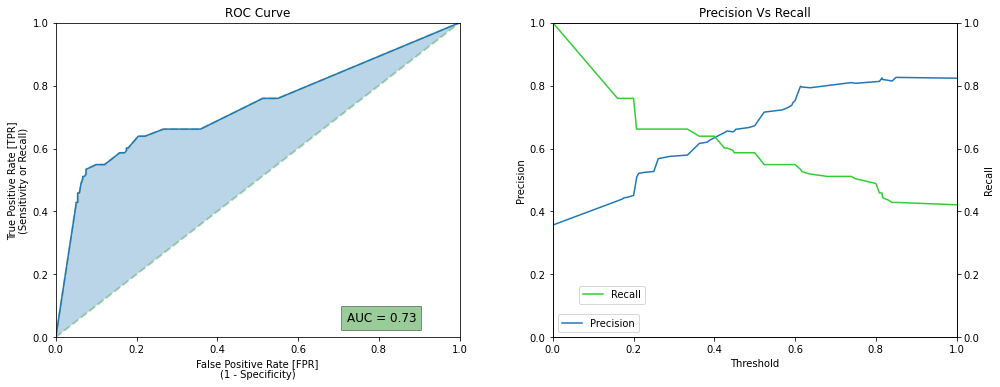

In [145]:
knn = KNeighborsClassifier(weights='distance')


nn, knn_report = lib.report(knn,x_train_df_split_transformed, y_train_split,
                                        x_test_df_cast_split_transformed, y_test_split,
                                        display_scores=[primary_eval_metric],
                                        importance_plot=True,
                                        feature_labels=feature_names,
                                        confusion_labels=confusion_lbs)

In [146]:
knn = KNeighborsClassifier(weights='distance')

In [147]:
knn.fit(X_train, y_train)
print(classification_report(y_train, knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       958
           1       0.93      0.75      0.83       532

    accuracy                           0.89      1490
   macro avg       0.90      0.86      0.87      1490
weighted avg       0.89      0.89      0.89      1490



## Escalando

In [155]:
knn_cv = GridSearchCV(estimator =  KNeighborsClassifier(), param_grid = search_params_knn, cv=5, scoring='f1', n_jobs=-1 , verbose = 0 , refit = True  )

knn_cv.fit(x_train_df_split_transformed_scaled, y_train_split)

knn_cv.best_estimator_

KNeighborsClassifier(n_neighbors=4, p=3, weights='distance')

KNeighborsClassifier(n_neighbors=4, p=3, weights='distance')

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 1117 samples
 Test Size: 373 samples
---------------------------------------------
Training Time: 0.001 seconds
 Testing Time: 0.12 seconds
---------------------------------------------
Train Accuracy:  0.9051029543419875
 Test Accuracy:  0.7426273458445041
---------------------------------------------
Train F1 Score:  0.8507042253521127
 Test F1 Score:  0.5897435897435898

---------------------------------------------
 Area Under ROC (test):  0.7252819548872179
---------------------------------------------
Model Memory Size: 175.33 kB

=============================> CLASSIFICATION REPORT <===================================
                    precision    recall  f1-score   support

No TravelInsurance       0.76      0.87      0.81       240
   TravelInsurance       0.68      0.52      0.59       133

          accuracy   

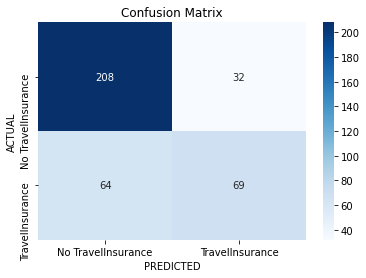


=======================================> PLOTS <=========================================


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


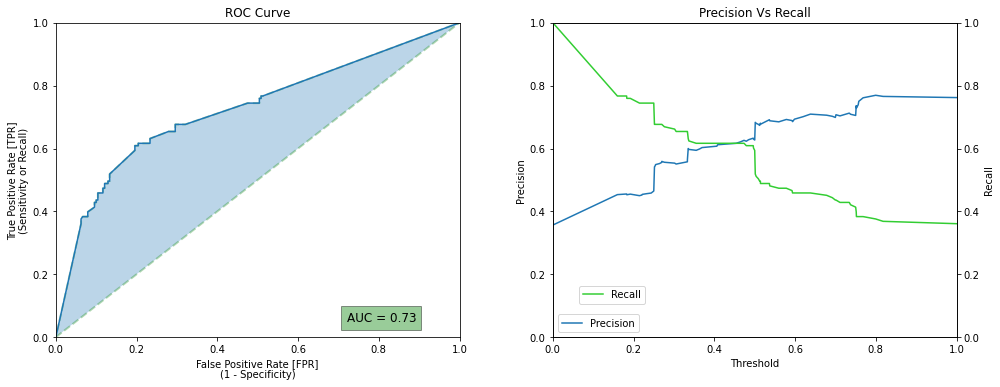

In [156]:
knn = KNeighborsClassifier(n_neighbors=4, p=3, weights='distance')

nn, knn_report = lib.report(knn,x_train_df_split_transformed_scaled, y_train_split,
                                        x_test_df_cast_split_transformed_scaled, y_test_split,
                                        display_scores=[primary_eval_metric],
                                        importance_plot=True,
                                        feature_labels=feature_names,
                                        confusion_labels=confusion_lbs)

In [159]:
knn = KNeighborsClassifier(n_neighbors=4, p=3, weights='distance')

In [161]:
knn.fit(X_train_scaled, y_train)
print(classification_report(y_train, knn.predict(X_train_scaled)))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       958
           1       0.91      0.76      0.83       532

    accuracy                           0.89      1490
   macro avg       0.89      0.86      0.87      1490
weighted avg       0.89      0.89      0.88      1490



In [180]:
## Usando PCA

In [181]:
search_params_knn = {
    'n_neighbors': [3,4,5,6,8,10],
    'p': [ 2, 3, 4],
    'weights': ['distance']
}




In [182]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
x_train_df_split_transformed_scaled_pca = pca.fit_transform(x_train_df_split_transformed_scaled)
x_test_df_cast_split_transformed_scaled_pca = pca.transform(x_test_df_cast_split_transformed_scaled)


X_train_scaled_pca = pca.transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

In [183]:
knn_cv = GridSearchCV(estimator =  KNeighborsClassifier(), param_grid = search_params_knn, cv=5, scoring='f1', n_jobs=-1 , verbose = 0 , refit = True  )

knn_cv.fit(x_train_df_split_transformed_scaled_pca, y_train_split)

knn_cv.best_estimator_

KNeighborsClassifier(n_neighbors=4, p=4, weights='distance')

In [184]:
X_train_pca.shape

(1490, 3)

KNeighborsClassifier(n_neighbors=4, p=4, weights='distance')

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 1117 samples
 Test Size: 373 samples
---------------------------------------------
Training Time: 0.001 seconds
 Testing Time: 0.003 seconds
---------------------------------------------
Train Accuracy:  0.9077887197851388
 Test Accuracy:  0.7587131367292225
---------------------------------------------
Train F1 Score:  0.8563458856345886
 Test F1 Score:  0.6250000000000001

---------------------------------------------
 Area Under ROC (test):  0.7342731829573934
---------------------------------------------
Model Memory Size: 76.18 kB

=============================> CLASSIFICATION REPORT <===================================
                    precision    recall  f1-score   support

No TravelInsurance       0.78      0.87      0.82       240
   TravelInsurance       0.70      0.56      0.63       133

          accuracy   

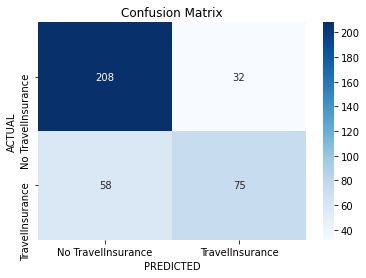


=======================================> PLOTS <=========================================


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


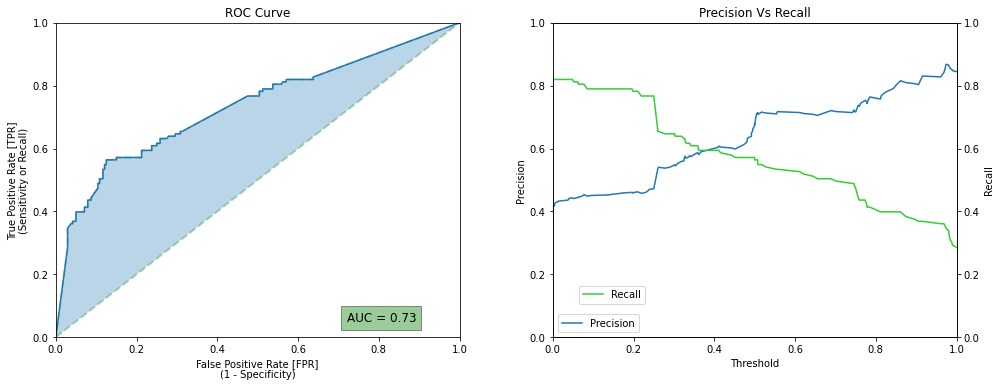

In [185]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance' , p = 4)

nn, knn_report = lib.report(knn,x_train_df_split_transformed_scaled_pca, y_train_split,
                                        x_test_df_cast_split_transformed_scaled_pca, y_test_split,
                                        display_scores=[primary_eval_metric],
                                        importance_plot=True,
                                        feature_labels=feature_names,
                                        confusion_labels=confusion_lbs)

In [200]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance' , p = 4)

In [201]:
knn.fit(X_train_scaled_pca, y_train)
print(classification_report(y_train, knn.predict(X_train_scaled_pca)))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       958
           1       0.95      0.73      0.83       532

    accuracy                           0.89      1490
   macro avg       0.91      0.86      0.87      1490
weighted avg       0.90      0.89      0.89      1490

